In [239]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns

device = 'mps'

In [240]:
path_to_pt_ekyn = f'../../sleep/pt_ekyn'
recording_filenames = os.listdir(path_to_pt_ekyn)
X,y = torch.load(f'{path_to_pt_ekyn}/{recording_filenames[0]}')
X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz
dataloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=True)
Xi,yi = next(iter(dataloader))
print(Xi.shape,yi.shape)

torch.Size([512, 1, 500]) torch.Size([512, 3])


In [242]:
class CNNSleepStager(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c1 = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(in_features=64,out_features=3)
    def forward(self,x):
        x = self.c1(x)
        x = relu(x)
        x = self.gap(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x
    
model = CNNSleepStager()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-2)
criterion = nn.CrossEntropyLoss()

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


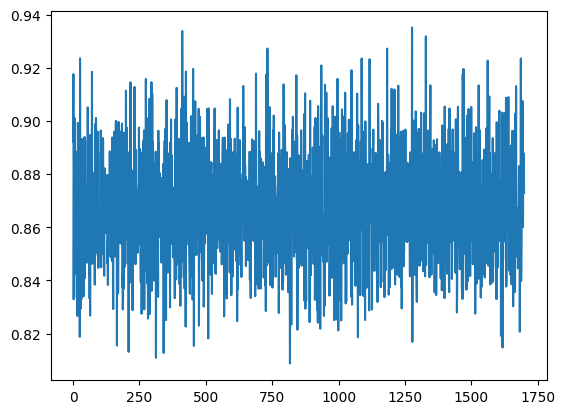

In [245]:
model.to(device)
lossi = []

for epoch in tqdm(range(100)):
    for Xi,yi in dataloader:
        Xi,yi = Xi.to(device),yi.to(device)
        optimizer.zero_grad()
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)